In [1]:
# Import librairies needed for this project
import warnings
warnings.filterwarnings("ignore")

from authentification_token import string_connection
from sqlalchemy import create_engine
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gc

import nltk
nltk.download("stopwords")
from nlp_utils_autism import remove_stopwords, normalize_corpus, plot_top_words
from sklearn.feature_extraction.text import  TfidfVectorizer

from sklearn.decomposition import NMF, LatentDirichletAllocation

from gensim.corpora.dictionary import Dictionary
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package stopwords to /home/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This project is the following of a Proof Of Concept about analysis of Reddit posts about ADHD. After concluding, it was possible to do some NLP analysis on this kind of text. Data about autism was collected in order to continue the analysis. This project is a proof of concept which the aim is to test different algorithms and methods  from NLP to analyse Reddit's posts.

## Cleaning

After running ETL script to collect data, we obtain three csv files. These csv files are going to be join before beginning the analysis.

In [2]:
STRING_CONNECTION = string_connection
engine = create_engine(STRING_CONNECTION)

In [3]:
df = pd.read_sql("reddit_extraction", con=engine)
df.drop("url", axis = 1, inplace=True)
df.head()

,index,title,score,id,num_comments,text,subreddit_name
0,2,"Dear *those* autistic men,",345,13h5ymk,123,Our lives aren't automatically better then you...,Autism
1,3,You only accept it as long as it doesn’t incon...,1085,13gyesp,48,None,Autism
2,4,Yeah basically.,434,13gxkud,8,None,Autism
3,5,"""i feel like neurotypical people actually enjo...",807,13gsoty,37,None,Autism
4,6,"Or, if I have different colors, I have to eat ...",425,13gxlkt,16,None,Autism


In [4]:
df.drop_duplicates('id', inplace=True)

In [5]:
df.dropna(inplace=True)
df.shape

(5809, 7)

## Data Analysis

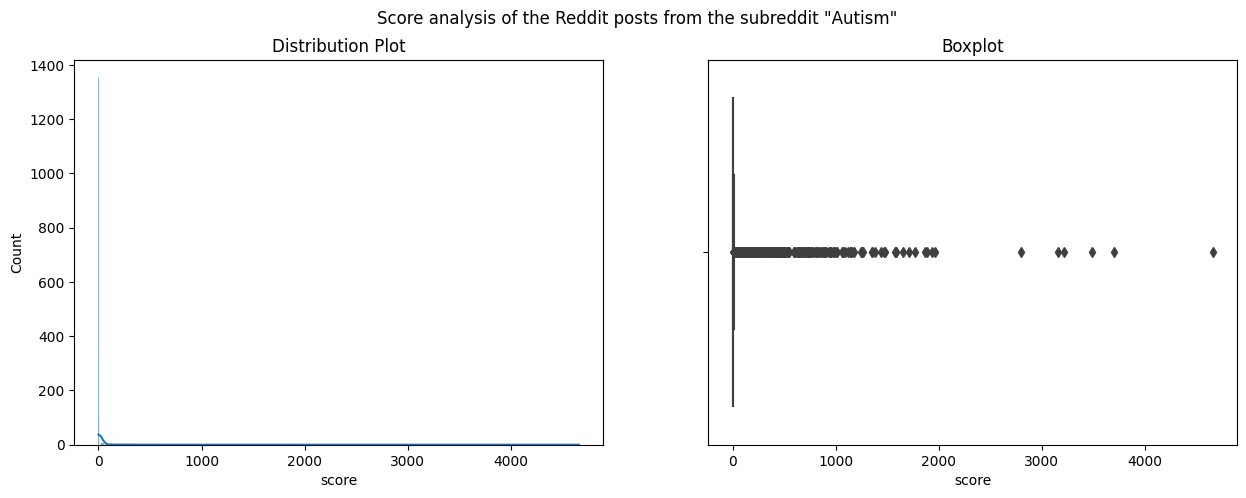

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Score analysis of the Reddit posts from the subreddit "Autism"')

sns.histplot(ax=axes[0], x="score", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="score", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [7]:
print("Mean score:", (np.mean(df["score"])).round(2))
print("Median score:", np.median(df["score"]))

Mean score: 32.38
Median score: 2.0


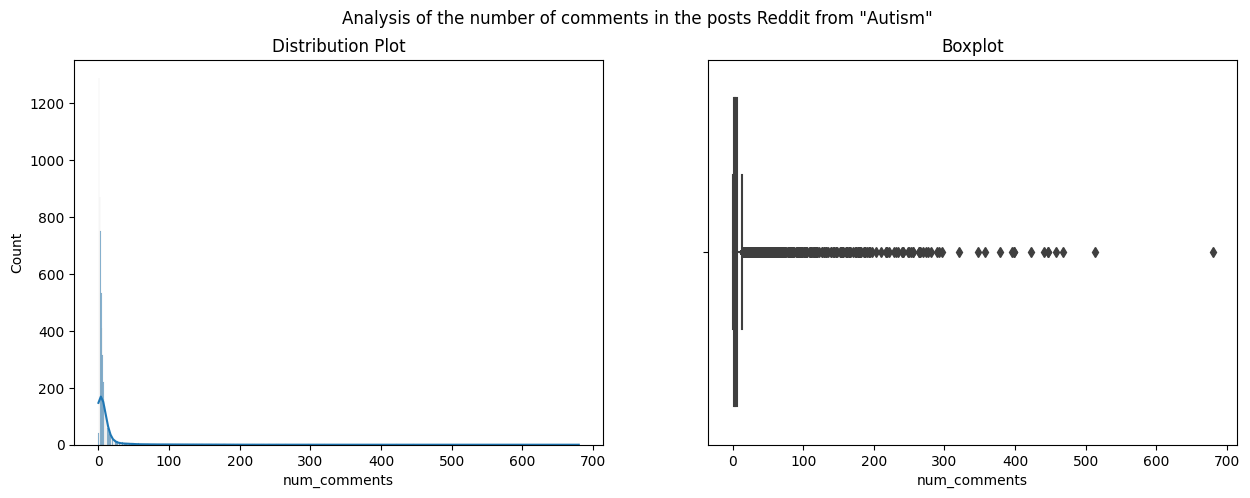

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Analysis of the number of comments in the posts Reddit from "Autism"')

sns.histplot(ax=axes[0], x="num_comments", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="num_comments", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [9]:
print("Mean number of comments: ", (np.mean(df["num_comments"]).round(2)))
print("Median number of comments: ", np.median(df["num_comments"]))

Mean number of comments:  11.16
Median number of comments:  3.0


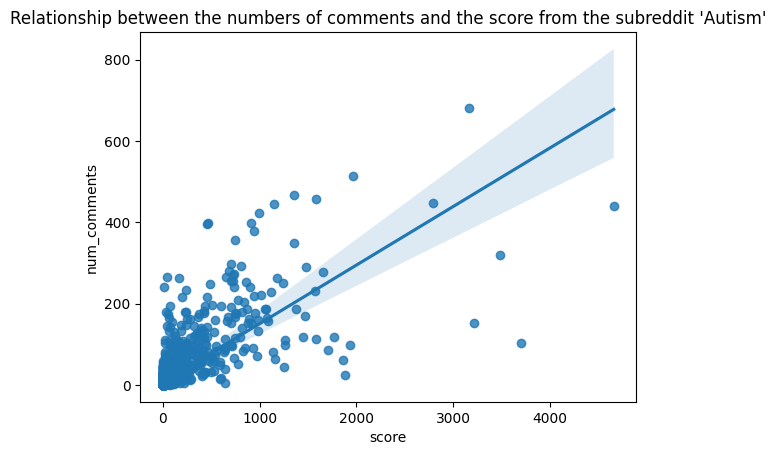

In [10]:
sns.regplot(x="score",
            y="num_comments",
            data=df)
plt.title("Relationship between the numbers of comments and the score from the subreddit 'Autism'")
plt.show()

## Title Analysis

In [11]:
df_title = df[["title"]]
df_title.head()

,title
0,"Dear *those* autistic men,"
6,I am a server. I waited on someone with autism...
7,"The Love of my life, while on the spectrum…"
9,DJing has been a great way for me to share one...
10,It makes me extremely angry that we don’t have...


In [12]:
df_title["title_norm"] = normalize_corpus(df_title["title"])
df_title.head()

,title,title_norm
0,"Dear *those* autistic men,",dear man
6,I am a server. I waited on someone with autism...,I server I wait stop think
7,"The Love of my life, while on the spectrum…",love life
9,DJing has been a great way for me to share one...,djing great I share one special interest also ...
10,It makes me extremely angry that we don’t have...,I extremely angry male sa statistic


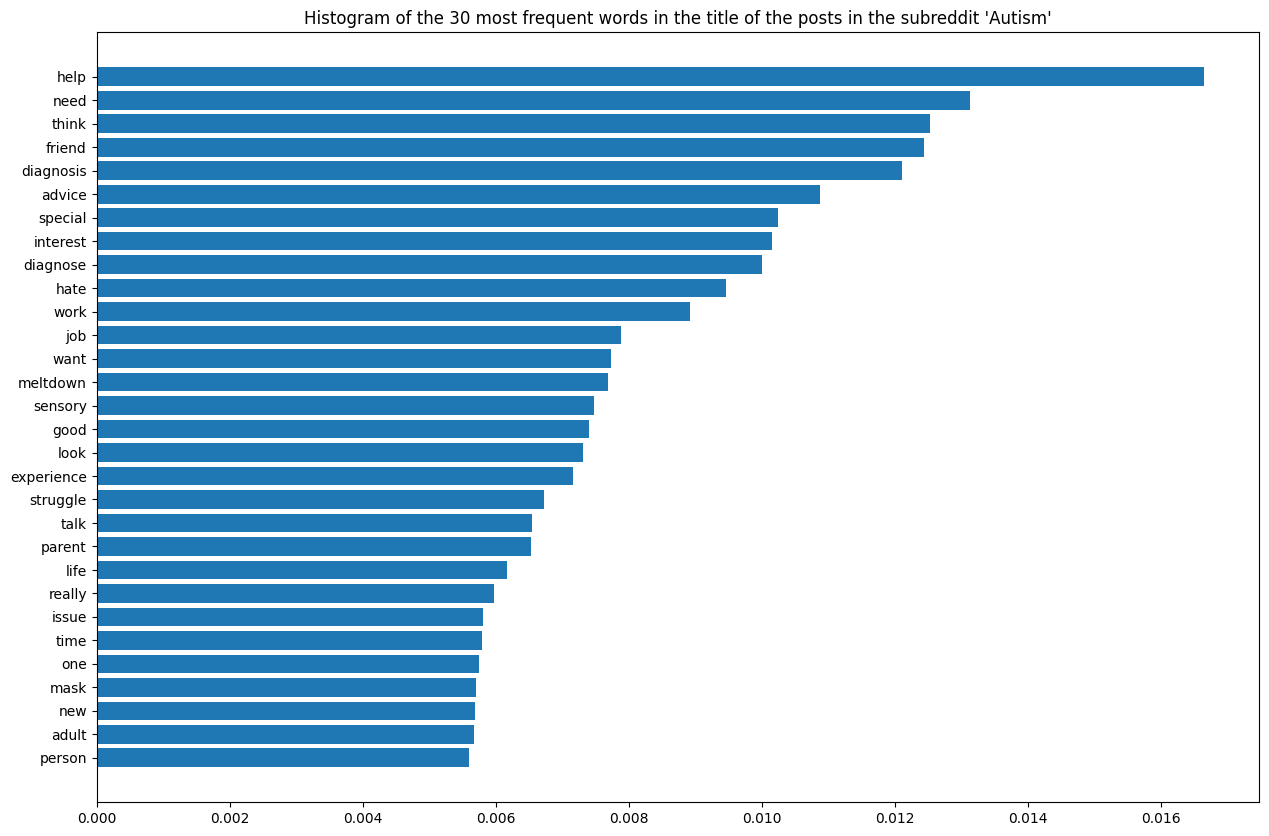

In [13]:
vectorizer_tf = TfidfVectorizer(analyzer = "word")
tfidf_title = vectorizer_tf.fit_transform(df_title['title_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.mean(), columns=["Value"])
df_title_tf = df_title_tf.sort_values("Value",ascending=False)
df_title_tf = df_title_tf.head(30)
df_title_tf = df_title_tf.sort_values("Value", ascending=True)

plt.figure(figsize = (15,10))
plt.barh(y = df_title_tf.index, 
         width = df_title_tf["Value"])
plt.title("Histogram of the 30 most frequent words in the title of the posts in the subreddit 'Autism'")
plt.show()

In [14]:
df_title.to_csv("data/autism-title.csv")

In [15]:
del(df_title)
gc.collect()

511437

## Content Analysis

In [16]:
df_text = df[["text"]]

In [17]:
df_text["text_norm"] = normalize_corpus(df_text["text"])
df_text.head()

,text,text_norm
0,Our lives aren't automatically better then you...,life automatically well stuggle girlfriend man...
6,I (20M) work at a popular soul food chain in t...,I work popular soul food chain southeast part ...
7,"Ever since I was 11 years old, I’ve always wan...",ever since I year old I always want girlfriend...
9,I have been DJing for about 5 years and am now...,I dj year gig I actually enjoy I want share sm...
10,9/10 Afab autistic people get SAed in their li...,afab saed lifetime I attempt amab statistic si...


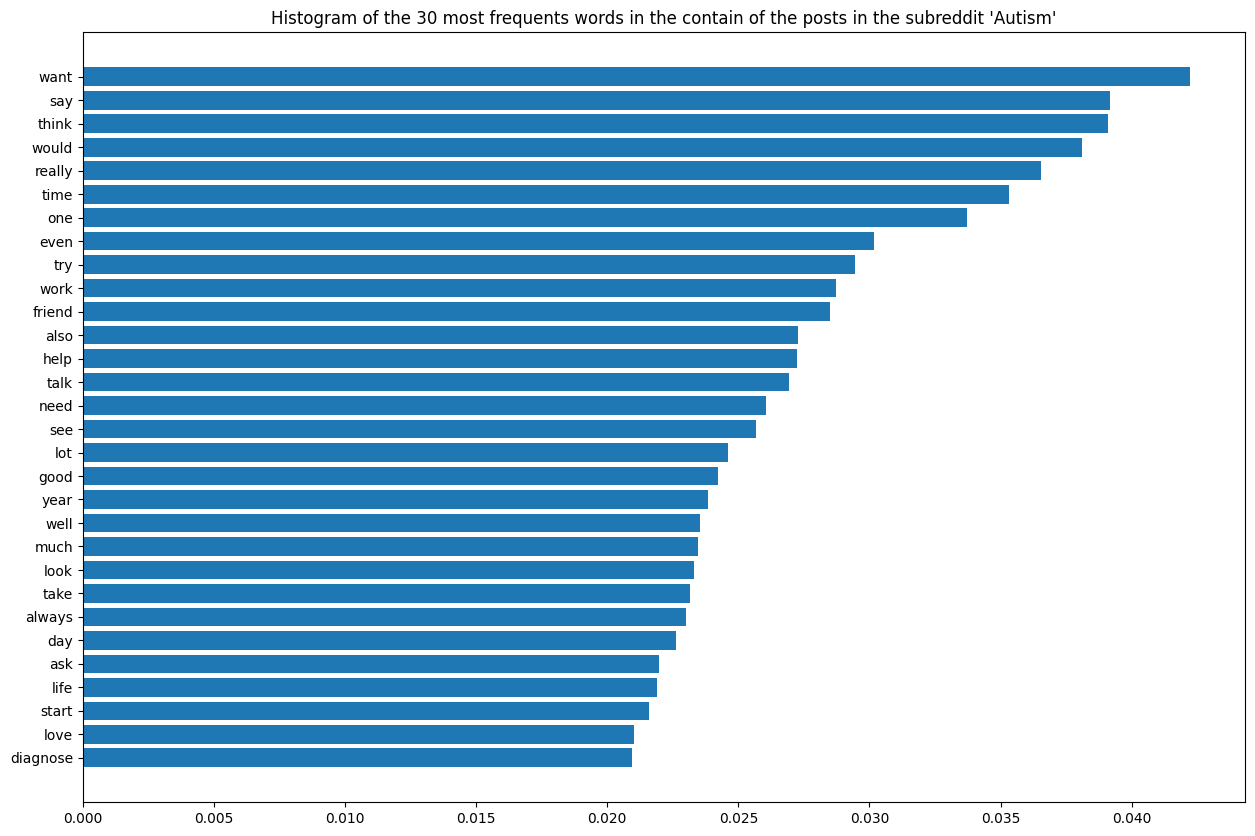

In [18]:
vectorizer_tf = TfidfVectorizer(max_features=500)
tfidf_text = vectorizer_tf.fit_transform(df_text['text_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_text_tf = pd.DataFrame(tfidf_text, columns=feature_names)
df_text_tf = pd.DataFrame(df_text_tf.mean(), columns=["Value"])
df_text_tf = df_text_tf.sort_values("Value",ascending=False)
df_text_tf = df_text_tf.head(30)
df_text_tf = df_text_tf.sort_values("Value", ascending = True)

plt.figure(figsize=(15,10))
plt.barh(y=df_text_tf.index,
         width=df_text_tf['Value'])
plt.title("Histogram of the 30 most frequents words in the contain of the posts in the subreddit 'Autism'")
plt.show()

In [19]:
df_text.to_csv("data/autism-text.csv")
del(df_text)
gc.collect()

7643

## Topic modeling

In [20]:
data_title = pd.read_csv("data/autism-title.csv")
data_text = pd.read_csv("data/autism-text.csv")

In [21]:
data_title.dropna(inplace=True)
data_text.dropna(inplace=True)

In [22]:
docs = data_title["title_norm"] + " " + data_text["text_norm"]

In [23]:
docs = docs.values.astype('U')

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [25]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.405 %


### NMF

In [26]:
nmf = NMF(n_components = 10,
          random_state = 42)
nmf.fit_transform(tfidf)

array([[2.49634062e-002, 1.37117897e-101, 8.70655255e-004, ...,
        1.57892548e-003, 8.48699420e-003, 4.75475875e-003],
       [5.00276551e-002, 9.25584608e-102, 1.55723173e-002, ...,
        0.00000000e+000, 7.71899113e-005, 4.41855229e-003],
       [4.20490364e-002, 1.23376894e-101, 3.16317630e-002, ...,
        1.66206504e-003, 0.00000000e+000, 5.90452251e-002],
       ...,
       [2.37857506e-002, 0.00000000e+000, 0.00000000e+000, ...,
        2.87814952e-004, 0.00000000e+000, 0.00000000e+000],
       [9.15708509e-003, 0.00000000e+000, 0.00000000e+000, ...,
        4.69769511e-004, 0.00000000e+000, 3.74690235e-003],
       [6.41367244e-002, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 1.28319034e-003]])

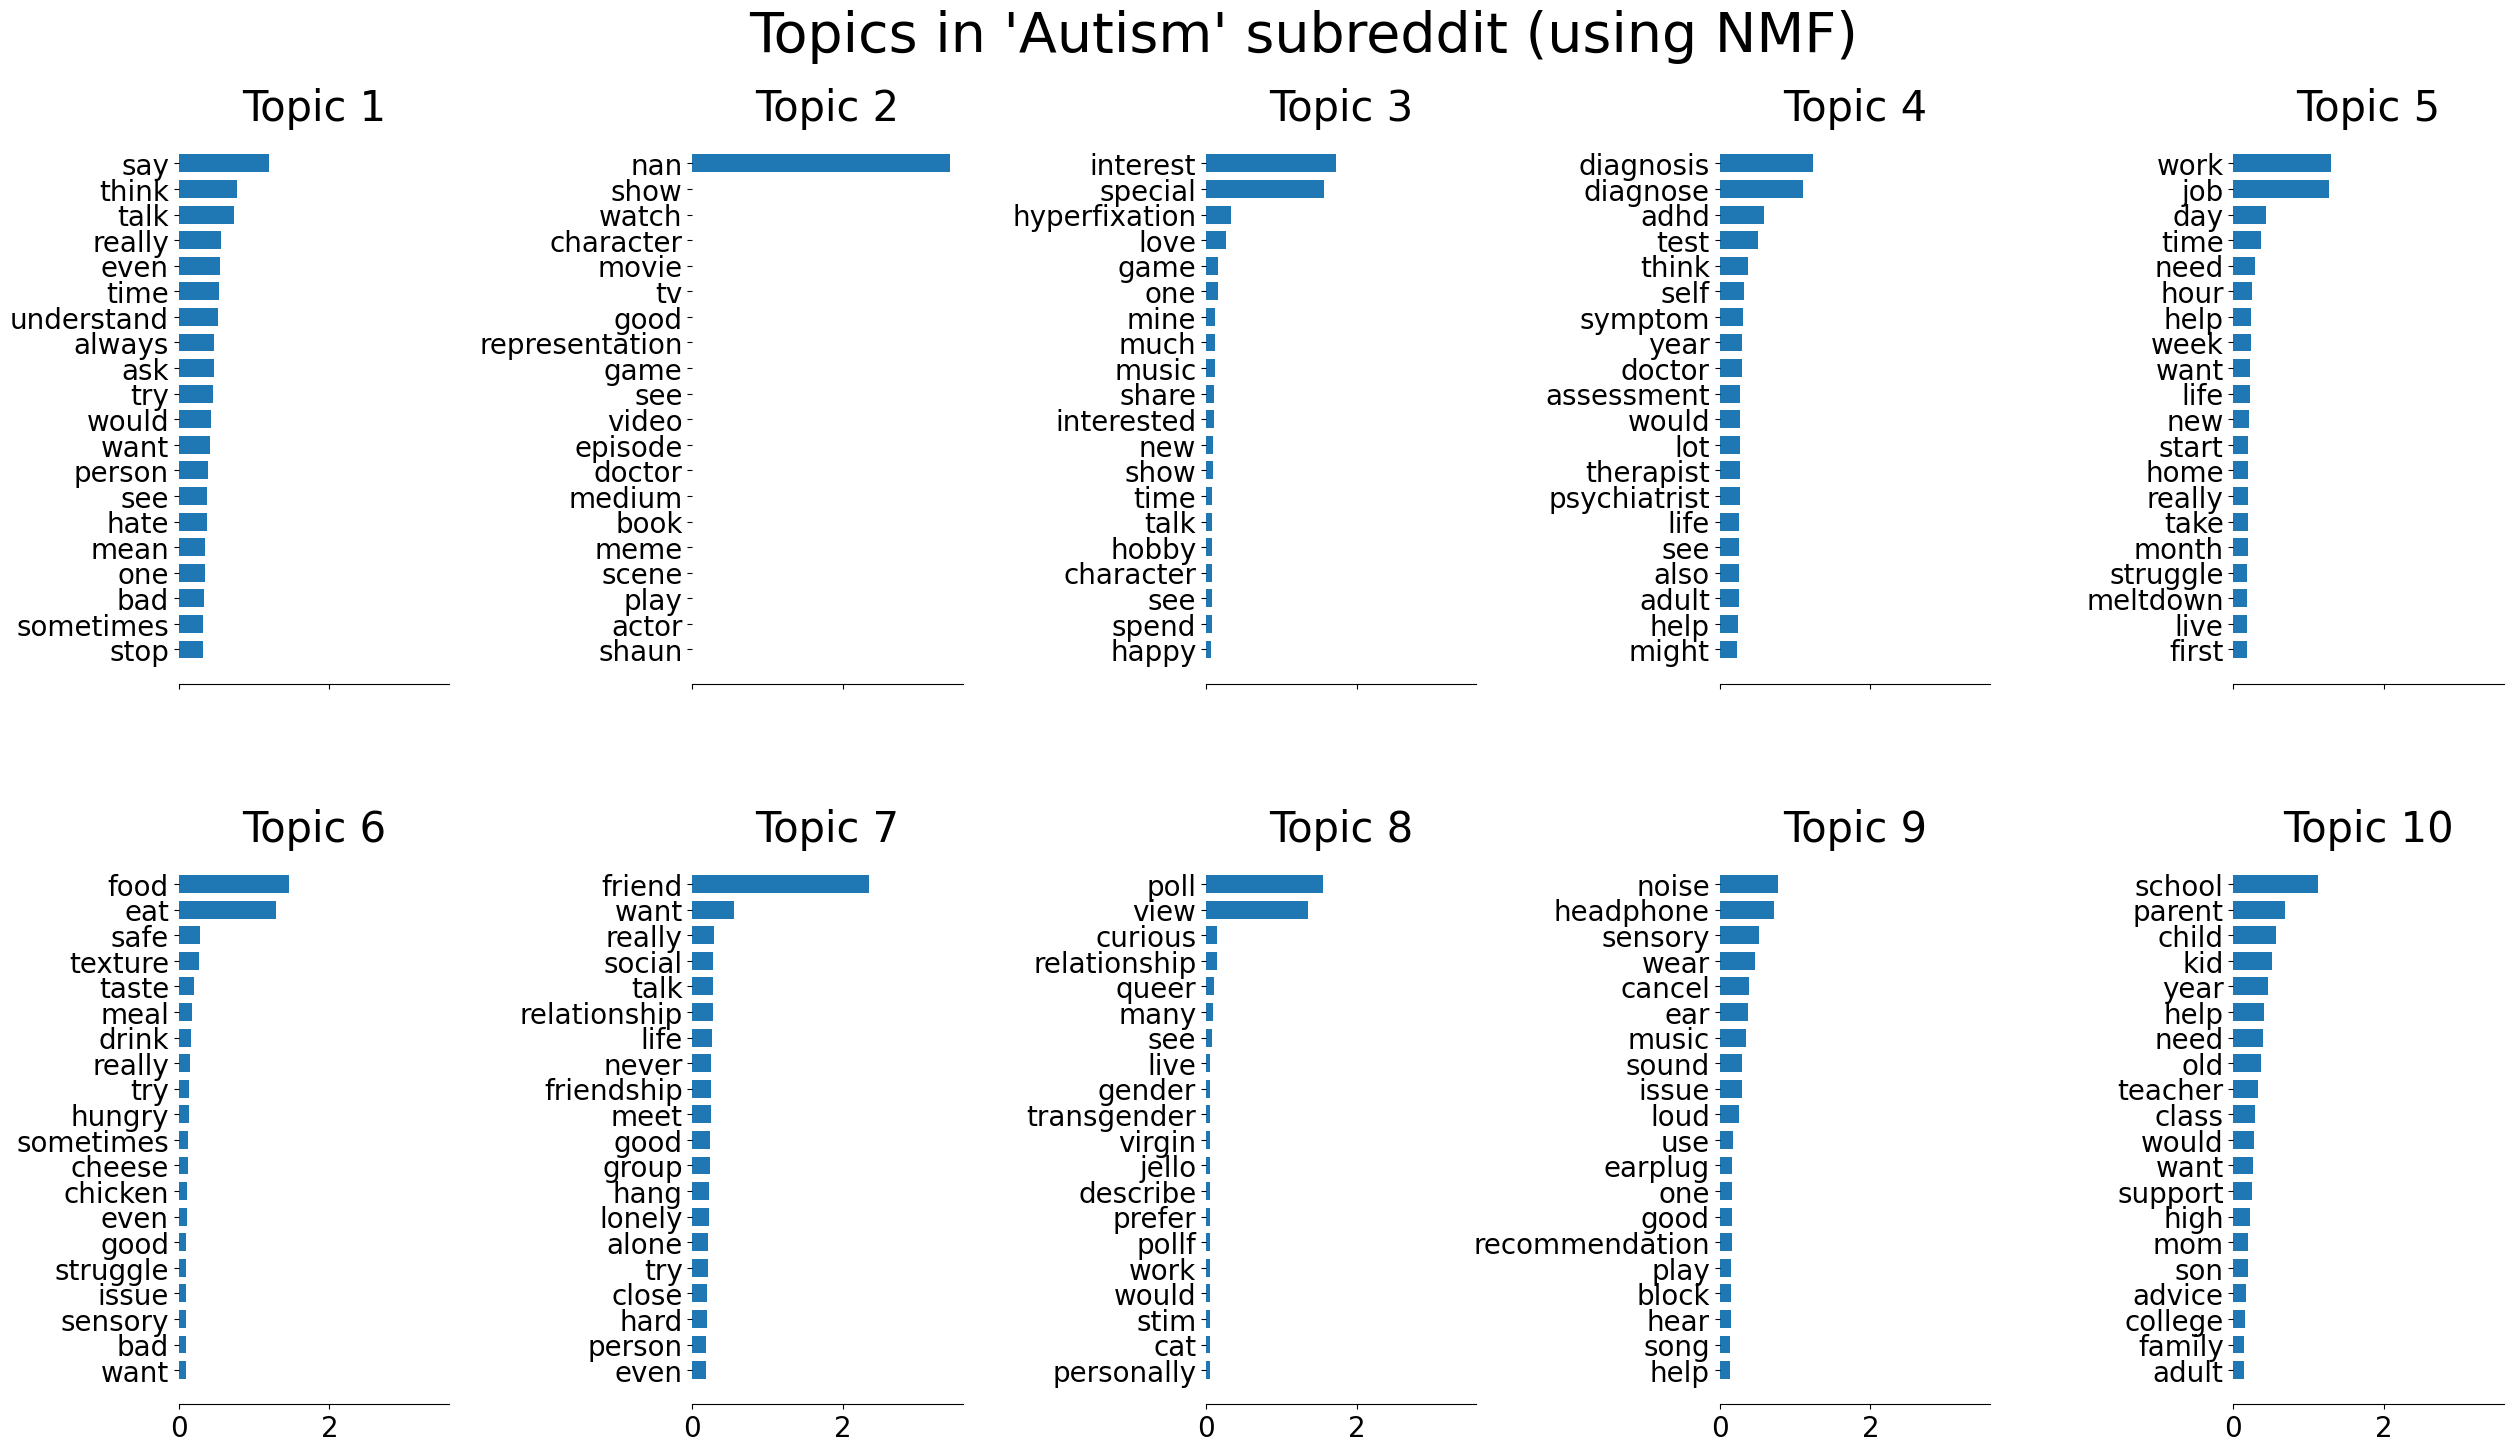

In [27]:
plot_top_words(nmf, 
               tfidf_feature_names, 
               n_top_words = 20, 
               title = "Topics in 'Autism' subreddit (using NMF)")

In [28]:
del nmf
gc.collect()

49698

### Latent Dirichlet Allocation

In [29]:
lda = LatentDirichletAllocation(n_components= 10,
                                random_state=42,
                                batch_size=400)
lda.fit_transform(tfidf)

array([[0.01493823, 0.01494706, 0.18000521, ..., 0.70046672, 0.0149474 ,
        0.01493977],
       [0.01079443, 0.010829  , 0.01078092, ..., 0.69895248, 0.01093793,
        0.01096747],
       [0.01135337, 0.01135269, 0.01135316, ..., 0.81876601, 0.01135345,
        0.01136743],
       ...,
       [0.02479504, 0.02479504, 0.02479504, ..., 0.77684456, 0.02479504,
        0.02479504],
       [0.01781585, 0.01781584, 0.01781586, ..., 0.83965736, 0.01781584,
        0.01781591],
       [0.01234219, 0.01234219, 0.01234219, ..., 0.8627155 , 0.01234219,
        0.01234219]])

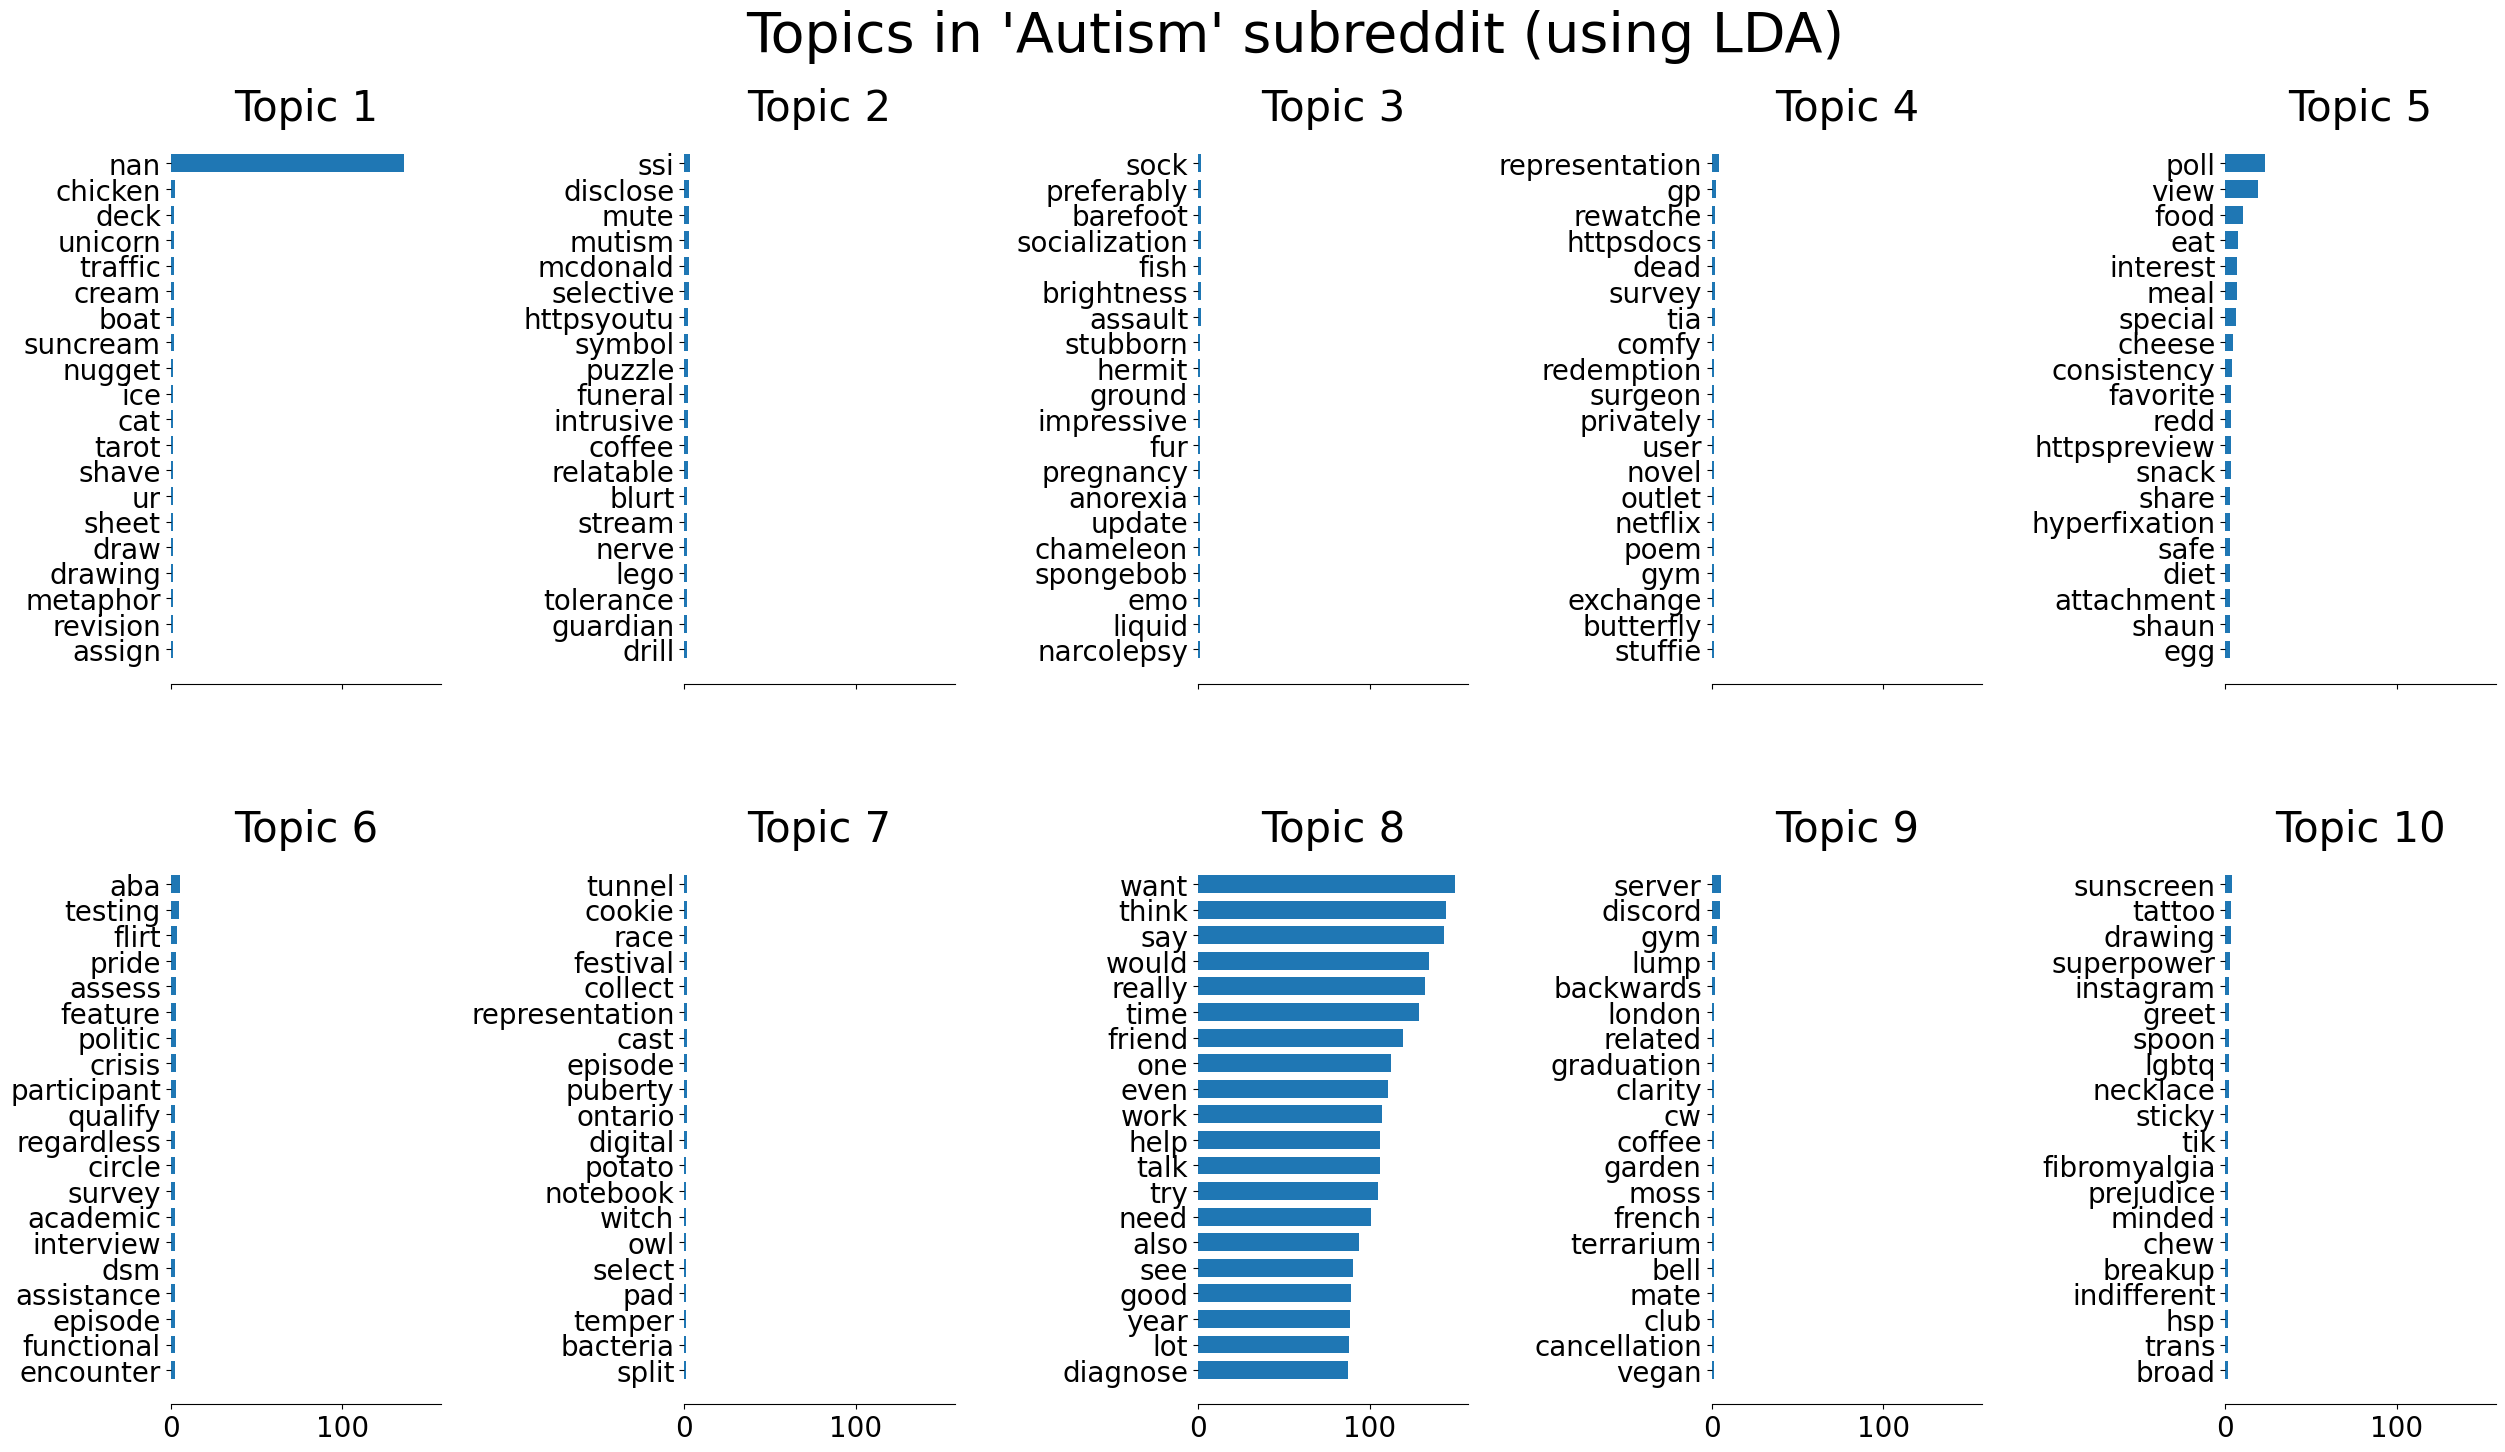

In [30]:
plot_top_words(lda, 
               tfidf_feature_names, 
               n_top_words = 20, 
               title = "Topics in 'Autism' subreddit (using LDA)")

In [31]:
del(lda)
gc.collect()

49697

### Evaluation du topic modeling

In [32]:
dataset = [d.split() for d in docs]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]

In [33]:
nmf = Nmf(corpus, num_topics=10, id2word=common_dictionary)
lda = LdaModel(corpus, num_topics=8, id2word=common_dictionary)

In [34]:
cm_nmf = CoherenceModel(model=nmf, texts=dataset, corpus=corpus, coherence='c_v')
coherence_nmf = cm_nmf.get_coherence()
cm_lda = CoherenceModel(model=lda, texts=dataset, corpus=corpus, coherence='c_v')
coherence_lda = cm_lda.get_coherence()

In [35]:
print("Coherence Model - NMF: ", coherence_nmf.round(3))
print("Coherence Model - LDA: ", coherence_lda.round(3))

Coherence Model - NMF:  0.311
Coherence Model - LDA:  0.322
